<div>
<img src="attachment:image-2.png" width="400"/>
</div>
<div>
<img src="attachment:image.png" width="600"/>
</div>
https://xkcd.com/1425/

## Is it a bird?

In [ ]:
from fastbook import *

urls = search_images_ddg('bird photos', max_images=1)
len(urls),urls[0]

(100, 'https://images7.alphacoders.com/416/thumb-1920-416332.jpg')

In [ ]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

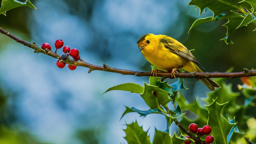

In [ ]:
im = Image.open(dest)
im.to_thumb(256,256)

All models need numbers as their inputs. Images are already stored as numbers in a computer -- here's a viewer so you can see what that looks like: [PixSpy](https://pixspy.com/).

In [ ]:
path = Path('bird_or_not')
searches = 'forest','bird'

if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

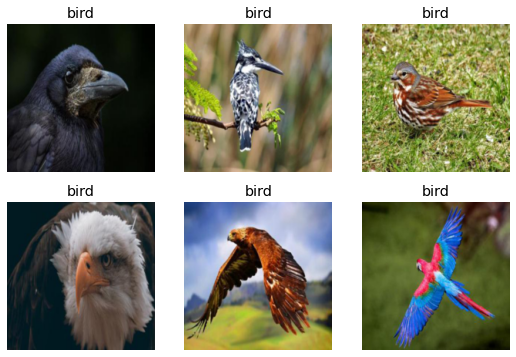

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.697321,1.035139,0.266667,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.060003,0.048283,0.026667,00:01
1,0.041999,0.001044,0.000000,00:01
2,0.029204,0.000355,0.000000,00:01


In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## What happened?

A normal computer program:


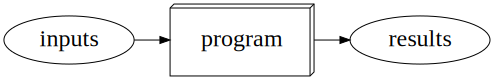

In [ ]:
gv2('''program[shape=box3d width=2 height=1]
inputs->program->results''')

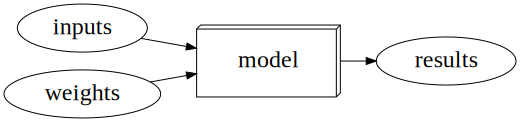

In [ ]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results; weights->model''')

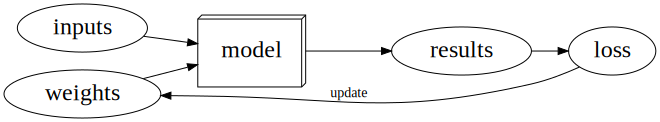

In [ ]:
gv2('''ordering=in
model[shape=box3d width=1.5 height=1]
inputs->model->results; weights->model; results->loss
loss->weights[constraint=false label=update]''')

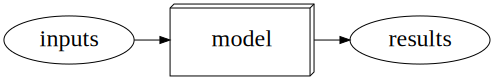

In [ ]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results''')

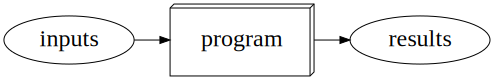

In [ ]:
gv2('''program[shape=box3d width=2 height=1]
inputs->program->results''')

## Not just for image recognition

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/home/jhoward/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,2.533562,2.346410,00:02


epoch,train_loss,valid_loss,time
0,1.686938,1.496451,00:01
1,1.482620,1.261210,00:01
2,1.358132,1.046232,00:01
3,1.272954,0.934707,00:01
4,1.175368,0.845012,00:01
5,1.081900,0.782854,00:01
6,0.997290,0.747329,00:01
7,0.929027,0.726728,00:01


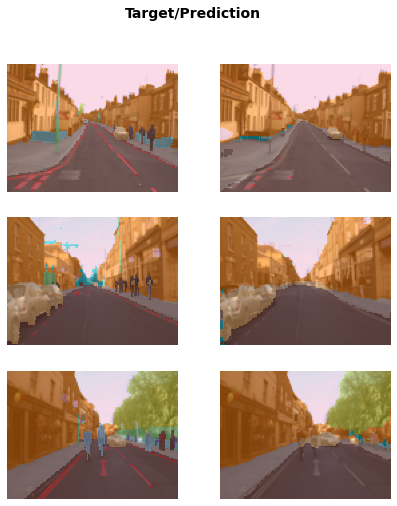

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))

In [ ]:
res,idx,probs = learn.predict("I really liked that movie!")
print(f"Sentiment: {res}; Probability it's pos: {probs[1]})

### Tabular analysis - income prediction

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Never-married,Other-service,Own-child,White,False,23.000001,117766.997603,9.0,<50k
1,Private,Some-college,Never-married,Handlers-cleaners,Not-in-family,White,False,46.000000,155664.001088,10.0,<50k
2,Private,9th,Never-married,Machine-op-inspct,Unmarried,White,False,22.000000,164775.000106,5.0,<50k
3,Local-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,42.000000,227890.001239,13.0,<50k
4,Private,9th,Never-married,Priv-house-serv,Unmarried,White,False,27.000000,363053.004449,5.0,<50k
5,Local-gov,Assoc-acdm,Never-married,Adm-clerical,Own-child,Black,False,22.000000,237811.001430,12.0,<50k
6,Private,9th,Divorced,Other-service,Not-in-family,White,False,47.000000,27815.003318,5.0,<50k
7,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,False,60.000000,216689.998834,10.0,<50k
8,State-gov,Bachelors,Never-married,Prof-specialty,Other-relative,White,False,37.000000,117651.000409,13.0,<50k
9,Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,False,42.000000,383493.001075,10.0,>=50k


In [ ]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

### Collaborative filtering - recommendation system

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [ ]:
dls.show_batch()

,userId,movieId,rating
0,176,4306,3.5
1,463,4886,4.0
2,313,3578,4.5
3,242,2858,5.0
4,17,608,3.5
5,382,356,3.0
6,547,480,3.0
7,119,457,3.0
8,358,2918,4.0
9,461,2571,4.5


In [ ]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.504887,1.435405,00:00


epoch,train_loss,valid_loss,time
0,1.357274,1.376017,00:00
1,1.261574,1.193945,00:00
2,1.037590,0.872405,00:00
3,0.794503,0.719316,00:00
4,0.697807,0.681823,00:00
5,0.660932,0.668036,00:00
6,0.632295,0.663469,00:00
7,0.618351,0.661946,00:00
8,0.601803,0.660737,00:00
9,0.603099,0.660635,00:00


In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,48.0,81.0,4.0,4.418300
1,92.0,13.0,4.0,3.547763
2,48.0,26.0,2.0,4.112822
3,69.0,96.0,3.0,3.968950
4,23.0,13.0,2.0,3.144361
5,40.0,41.0,5.0,3.927040
6,26.0,83.0,5.0,4.279118
7,92.0,93.0,4.5,4.338519
8,89.0,88.0,5.0,4.239862


## Overfitting

In [ ]:
plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

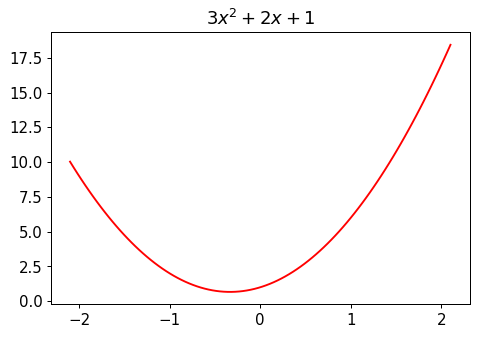

In [ ]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [ ]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

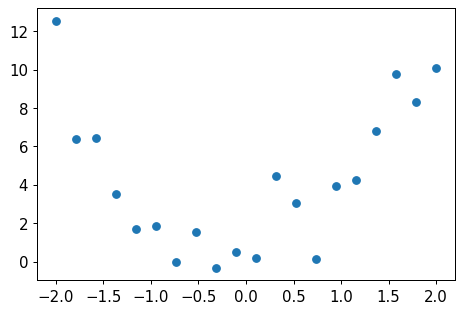

In [ ]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y);

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

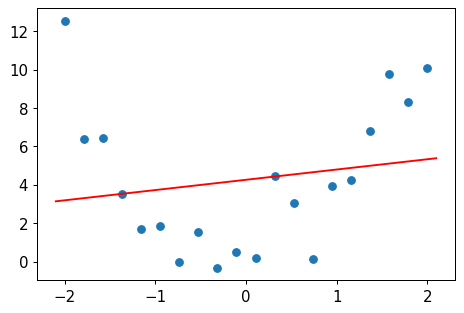

In [ ]:
plot_poly(1)

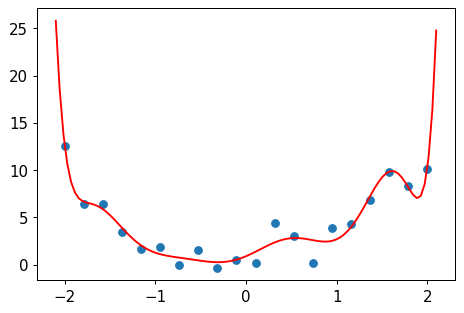

In [ ]:
plot_poly(10)

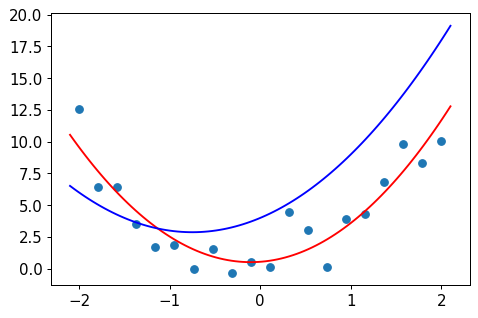

In [ ]:
plot_poly(2)
plot_function(f, color='b')

## How do we fit a function to data?

In [ ]:
def quad(a, b, c, x): return a*x**2 + b*x + c
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [ ]:
f = mk_quad(2,3,4)
quad(2,3,4,1.5), f(1.5)

(13.0, 13.0)

In [ ]:
from ipywidgets import interact

In [ ]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [ ]:
def mse(preds, acts): return ((preds-acts)**2).mean()

In [ ]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [ ]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

In [ ]:
quad_mse([1.5, 1.5, 1.5])

tensor(5.8336, dtype=torch.float64)

In [ ]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [ ]:
loss = quad_mse(abc)
loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

In [ ]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

In [ ]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
    
print(f'loss={loss:.2f}')

loss=5.49


In [ ]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=5.49
step=1; loss=4.90
step=2; loss=4.23
step=3; loss=3.67
step=4; loss=3.33


In [ ]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

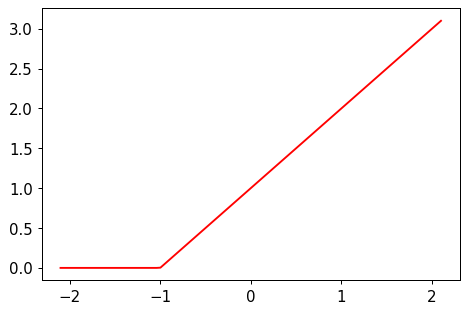

In [ ]:
plot_function(partial(rectified_linear, 1,1))

In [ ]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [ ]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

In [ ]:
@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

### fin -